In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from arviz import hdi
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Model Diagnostics

In [2]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3']

### 1.1 Stan diagnostics


In [3]:
## Main loop.
diagnostics = []
for m in models:
    
    for s in sessions:

        ## Load Stan summary.
        samples = read_csv(os.path.join('stan_results', s, f'{m}.tsv.gz'), sep='\t', compression='gzip')
        summary = read_csv(os.path.join('stan_results', s, f'{m}_summary.tsv'), sep='\t', index_col=0)
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Apply restrictions.
        ppc = ppc[~np.isinf(ppc.k_u)]                        # Removed fixed parameters.

        ## Identify number of divergences.
        divergence = samples.divergent__.sum()

        ## Identify parameters failing to reach convergence.
        rhat = len(summary.query('R_hat >= 1.02'))

        ## Identify parameters with low effective sample size.
        n_eff = len(summary.query('N_Eff < 400'))

        ## Identify number of effective parameters.
        p_loo = ppc.pwaic.sum()

        ## Identify number of poorly predicted observations.
        pk = np.sum(ppc.k_u > 0.7)

        ## Convert to dictionary. Append.
        diagnostics.append(dict(
            model = m,
            session = s,
            divergence = divergence,
            rhat = rhat,
            n_eff = n_eff,
            p_loo = np.round(p_loo, 1),
            pk = np.round(pk, 3)
        ))

## Convert to DataFrame.
diagnostics = DataFrame(diagnostics).sort_values(['session','model']).set_index(['session','model'])
diagnostics

divergence  rhat  n_eff  p_loo  pk
session model                                      
s1      pgng_m1         0.0     0      0   31.0  16
        pgng_m2         0.0     0      1   48.5   0
        pgng_m3         0.0     0      0   63.9   0
        pgng_m4         0.0     0      0   75.5   0
        pgng_m5         0.0     0      0   74.7   0
        pgng_m6         0.0     0      0   80.9   0
        pgng_m7         0.0     0      0   93.4   0
s2      pgng_m1         0.0     0      0   23.2  16
        pgng_m2         0.0     1      1   40.1   0
        pgng_m3         0.0     1      0   54.0   0
        pgng_m4         0.0     0      0   63.5   0
        pgng_m5         0.0     0      0   60.8   0
        pgng_m6         0.0     0      0   67.7   0
        pgng_m7         0.0     0      0   80.7   0
s3      pgng_m1         0.0     0      0   23.6  24
        pgng_m2         0.0     0      0   41.4   0
        pgng_m3         0.0     0      0   56.1   0
        pgng_m4         0.0     0      0   63.9   0
        pgng_m5         0.0     0      0   62.4   0
        pgng_m6         0.0     0      0   69.6   0
        pgng_m7         0.0     0      0   82.2   0

## Section 2: Model Comparison

In [4]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3']

### 2.1 LOO-CV indices

In [5]:
## Main loop.
loocv = []
for m in models:

    for s in sessions:
    
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute LOO-CV.
        loo = -2 * ppc.loo.sum()

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, loocv=loo))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'session', 'model')
loocv.round(1)

model,pgng_m1,pgng_m2,pgng_m3,pgng_m4,pgng_m5,pgng_m6,pgng_m7
session,,,,,,,
s1,-33517.7,-35145.3,-36002.4,-36074.8,-36117.1,-36124.5,-36264.1
s2,-31023.5,-31996.2,-32447.1,-32513.7,-32508.9,-32543.9,-32679.6
s3,-31265.0,-32474.5,-32833.5,-32833.9,-32893.1,-32880.4,-33067.8


### 2.2 Model comparisons

In [6]:
from itertools import combinations

loocv = []
for s in sessions:

    for a, b in list(combinations(models, 2)):

        ## Load data.
        ppc1 = read_csv(os.path.join('stan_results', s, f'{a}_ppc.csv'))
        ppc2 = read_csv(os.path.join('stan_results', s, f'{b}_ppc.csv'))

        arr = -2 * (ppc2.loo - ppc1.loo)

        ## Compute stats.
        N = len(ppc1)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, a=a, b=b, loocv='%0.1f (%0.1f)' %(mu, se)))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'a', ['session','b'], aggfunc=lambda x: x).fillna('-')
loocv

session              s1                                                   
b               pgng_m2         pgng_m3         pgng_m4         pgng_m5   
a                                                                         
pgng_m1  -1627.5 (37.9)  -2484.7 (45.9)  -2557.1 (47.6)  -2599.3 (47.5)  \
pgng_m2               -   -857.1 (28.6)   -929.5 (31.3)   -971.8 (31.3)   
pgng_m3               -               -    -72.4 (12.9)   -114.7 (12.3)   
pgng_m4               -               -               -     -42.3 (8.8)   
pgng_m5               -               -               -               -   
pgng_m6               -               -               -               -   

session                                             s2                   
b               pgng_m6         pgng_m7        pgng_m2         pgng_m3   
a                                                                        
pgng_m1  -2606.7 (48.2)  -2746.3 (48.6)  -972.7 (29.4)  -1423.5 (35.3)  \
pgng_m2   -979.2 (32.4)  -1118.8 (33.1)              -   -450.8 (21.6)   
pgng_m3   -122.1 (14.9)   -261.6 (16.8)              -               -   
pgng_m4     -49.7 (7.4)   -189.2 (12.0)              -               -   
pgng_m5      -7.4 (6.8)   -147.0 (10.7)              -               -   
pgng_m6               -    -139.6 (9.1)              -               -   

session                                                                   
b               pgng_m4         pgng_m5         pgng_m6         pgng_m7   
a                                                                         
pgng_m1  -1490.1 (37.0)  -1485.3 (37.1)  -1520.3 (37.7)  -1656.0 (38.0)  \
pgng_m2   -517.4 (24.4)   -512.6 (24.4)   -547.6 (25.3)   -683.3 (26.0)   
pgng_m3    -66.6 (12.1)    -61.8 (11.9)    -96.8 (13.8)   -232.5 (15.7)   
pgng_m4               -       4.8 (7.8)     -30.2 (6.6)   -165.9 (11.3)   
pgng_m5               -               -     -35.0 (6.1)   -170.7 (10.6)   
pgng_m6               -               -               -    -135.7 (9.1)   

session              s3                                                   
b               pgng_m2         pgng_m3         pgng_m4         pgng_m5   
a                                                                         
pgng_m1  -1209.5 (32.8)  -1568.5 (36.9)  -1568.9 (38.1)  -1628.1 (38.2)  \
pgng_m2               -   -359.1 (20.0)   -359.5 (22.3)   -418.6 (22.3)   
pgng_m3               -               -     -0.4 (10.6)    -59.6 (10.3)   
pgng_m4               -               -               -     -59.2 (7.4)   
pgng_m5               -               -               -               -   
pgng_m6               -               -               -               -   

session                                  
b               pgng_m6         pgng_m7  
a                                        
pgng_m1  -1615.4 (38.8)  -1802.8 (39.2)  
pgng_m2   -405.9 (23.4)   -593.4 (24.8)  
pgng_m3    -46.9 (12.7)   -234.3 (16.4)  
pgng_m4     -46.4 (6.0)   -233.9 (13.1)  
pgng_m5      12.7 (5.8)   -174.7 (11.9)  
pgng_m6               -   -187.5 (11.3)

### 2.3 Table 2

In [7]:
from sklearn.metrics import accuracy_score

## Define winning model.
winning = 'pgng_m7'

## Main loop.
loocv = []
for i, m in enumerate(models):

    ## Load posterior predictive checks.
    ppc1 = concat([read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))
                  for s in sessions])

    ## Load posterior predictive checks.
    ppc2 = concat([read_csv(os.path.join('stan_results', s, f'{winning}_ppc.csv'))
                  for s in sessions])
    
    ## Compute classification accuracy.
    score = accuracy_score(ppc1.choice, ppc1.Y_hat > 0.5) * 1e2
    
    ## Compute LOO-CV.
    loo = -2 * ppc1.loo.sum()
    
    ## Comute delta LOO-CV.
    arr = -2 * (ppc2.loo - ppc1.loo)
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(len(arr))
    
    ## Append.
    loocv.append(dict(model=i+1, score='%0.1f' %score, loo='%0.1f' %loo, delta='%0.1f (%0.1f)' %(mu, se)))
    
## Convert to DataFrame.
loocv = DataFrame(loocv).set_index('model')
loocv

,score,loo,delta
model,,,
1,72.9,-95806.3,-6205.2 (73.2)
2,76.5,-99616.0,-2395.5 (48.9)
3,77.6,-101283.0,-728.5 (28.2)
4,77.5,-101422.4,-589.0 (21.1)
5,77.7,-101519.0,-492.4 (19.1)
6,77.8,-101548.7,-462.7 (17.2)
7,78.1,-102011.4,0.0 (0.0)


### 2.4 Table S3

In [8]:
from sklearn.metrics import accuracy_score

## Define winning model.
winning = 'pgng_m7'

## Main loop.
loocv = []
for i, m in enumerate(models):

    for s in sessions:
    
        ## Load posterior predictive checks.
        ppc1 = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Load posterior predictive checks.
        ppc2 = read_csv(os.path.join('stan_results', s, f'{winning}_ppc.csv'))

        ## Compute classification accuracy.
        score = accuracy_score(ppc1.choice, ppc1.Y_hat > 0.5) * 1e2

        ## Compute LOO-CV.
        loo = -2 * ppc1.loo.sum()

        ## Comute delta LOO-CV.
        arr = -2 * (ppc2.loo - ppc1.loo)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(len(arr))

        ## Append.
        loocv.append(dict(model=i+1, session=s, score='%0.1f' %score, loo='%0.1f' %loo, 
                          delta='%0.1f (%0.1f)' %(mu, se)))
    
## Convert to DataFrame.
loocv = DataFrame(loocv).set_index(['session','model']).sort_index()
loocv

score       loo           delta
session model                                
s1      1      71.5  -33517.7  -2746.3 (48.6)
        2      75.4  -35145.3  -1118.8 (33.1)
        3      77.3  -36002.4   -261.6 (16.8)
        4      77.2  -36074.8   -189.2 (12.0)
        5      77.4  -36117.1   -147.0 (10.7)
        6      77.4  -36124.5    -139.6 (9.1)
        7      77.6  -36264.1       0.0 (0.0)
s2      1      74.0  -31023.5  -1656.0 (38.0)
        2      77.4  -31996.2   -683.3 (26.0)
        3      78.1  -32447.1   -232.5 (15.7)
        4      78.2  -32513.7   -165.9 (11.3)
        5      78.1  -32508.9   -170.7 (10.6)
        6      78.3  -32543.9    -135.7 (9.1)
        7      78.7  -32679.6       0.0 (0.0)
s3      1      73.3  -31265.0  -1802.8 (39.2)
        2      76.8  -32474.5   -593.4 (24.8)
        3      77.4  -32833.5   -234.3 (16.4)
        4      77.3  -32833.9   -233.9 (13.1)
        5      77.6  -32893.1   -174.7 (11.9)
        6      77.6  -32880.4   -187.5 (11.3)
        7      78.1  -33067.8       0.0 (0.0)

## Section 3: Posterior Predictive Checks

In [9]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5', 'pgng_m6', 'pgng_m7']
sessions = ['s1', 's2', 's3']

### 3.1 Group-level

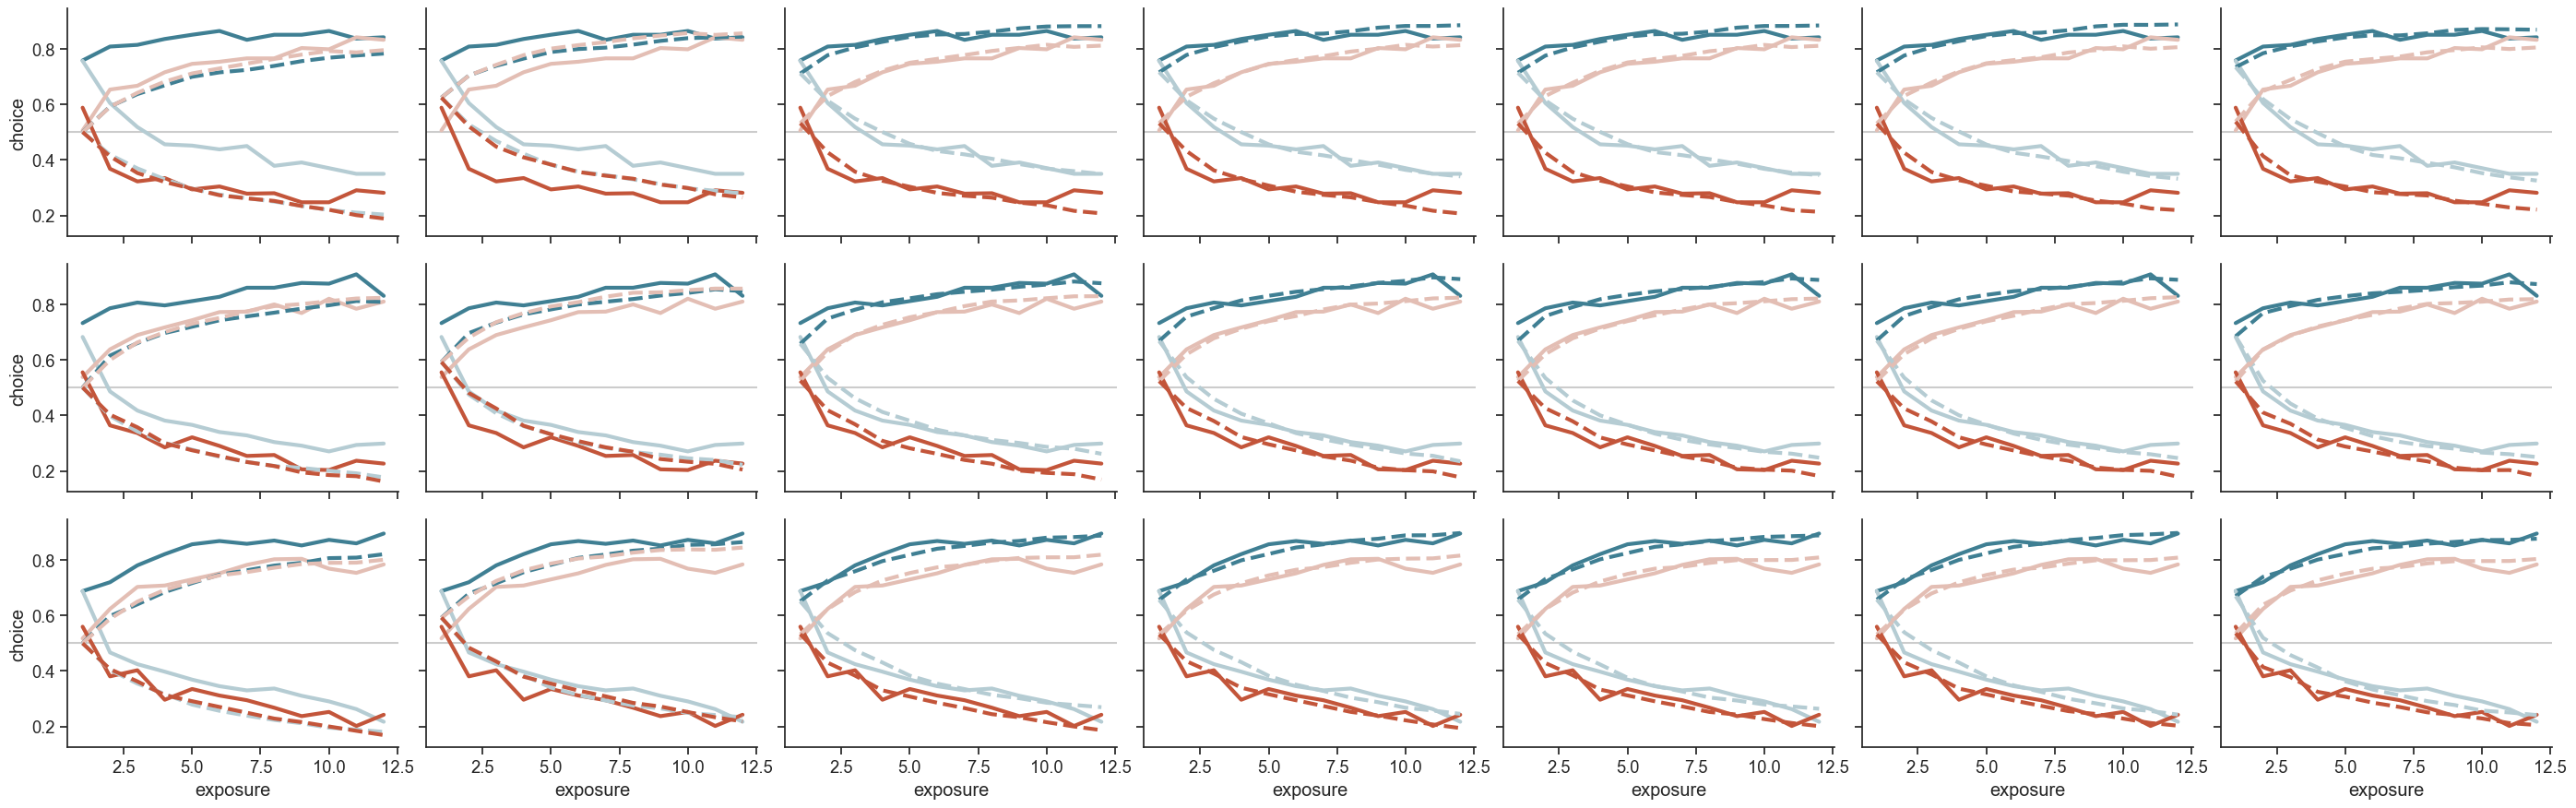

In [10]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*4, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))
            
        ## Plot learning curves.
        sns.lineplot(x='exposure', y='choice', hue='robot', data=ppc, hue_order=order,
                      palette=palette, lw=3, errorbar=None, ax=axes[i,j])
        sns.lineplot(x='exposure', y='Y_hat', hue='robot', data=ppc, hue_order=order, 
                      palette=palette, lw=3, errorbar=None, linestyle='--', ax=axes[i,j])

        ## Add trend line.
        axes[i,j].axhline(0.5, color='0.5', alpha=0.4, zorder=-10)
        
        ## Adjust legend.
        axes[i,j].legend_.set_visible(False)
        
sns.despine()
plt.tight_layout()

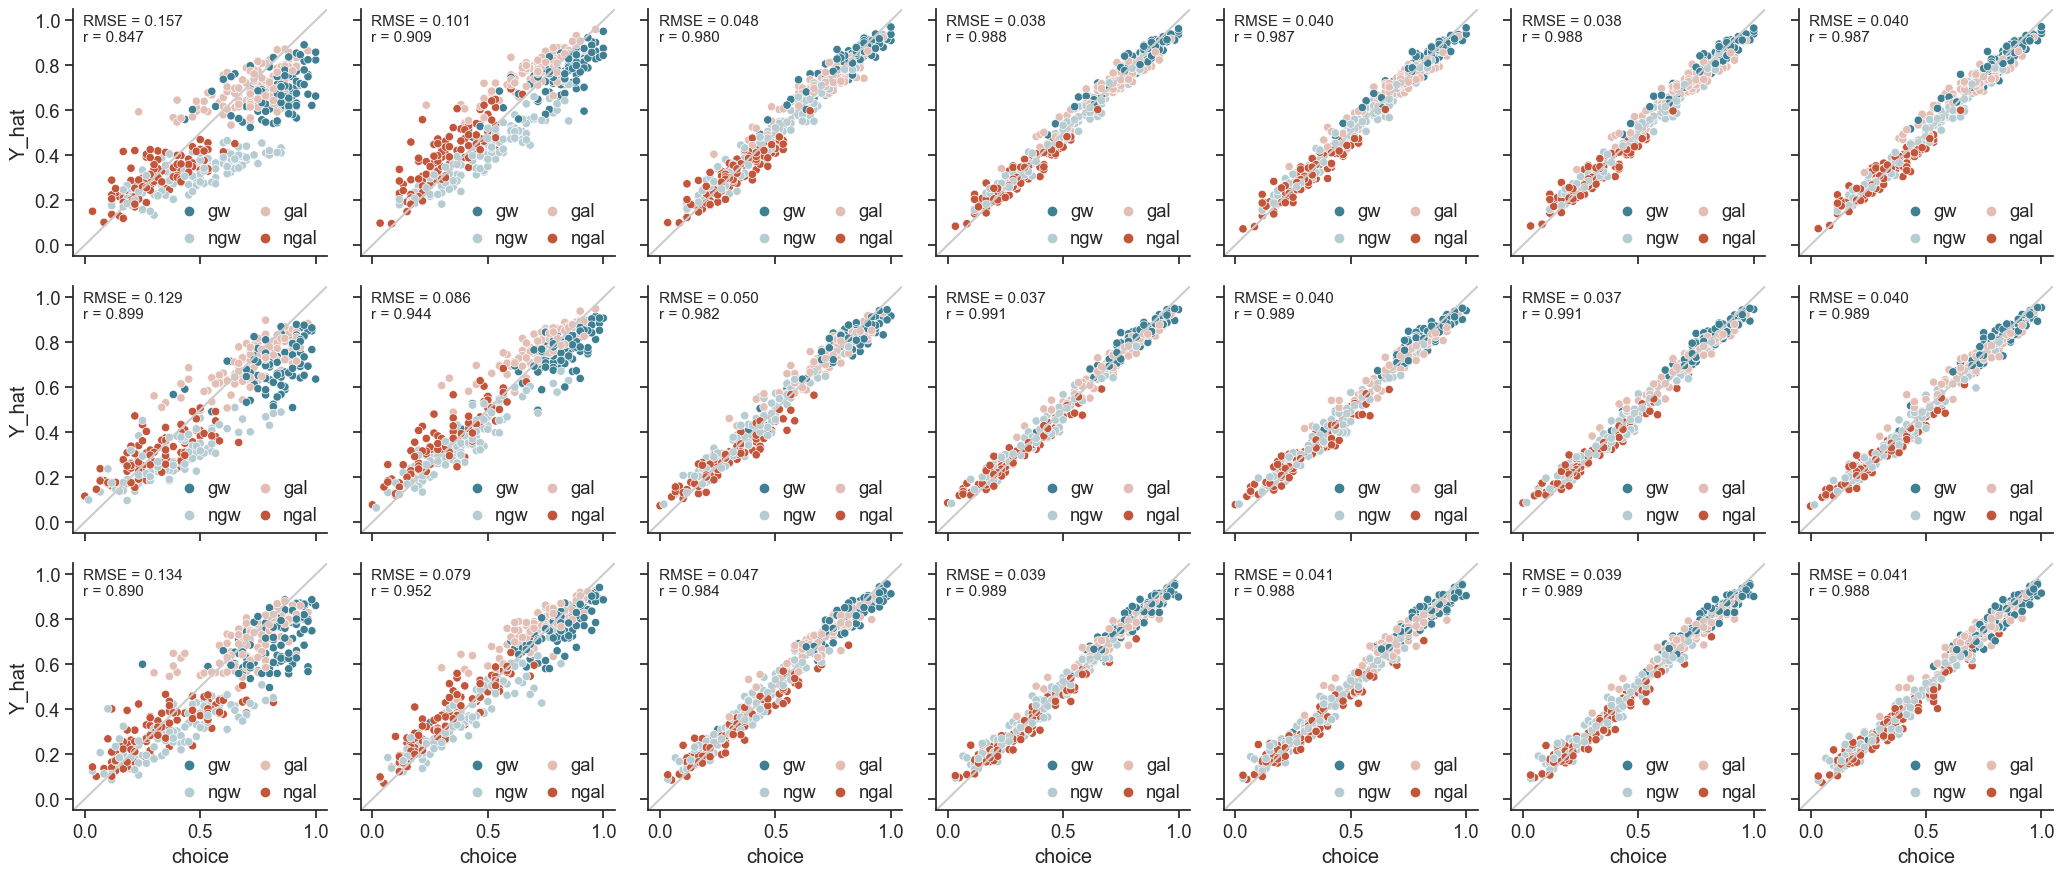

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*3, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

## Define convenience functions.
RMSE = lambda x: np.sqrt(np.mean(np.square(x)))

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute accuracy by participant / condition.
        gb = ppc.groupby(['subject','robot']).agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()
        
        ## Compute fit statistics.
        rmse = RMSE(gb.choice - gb.Y_hat)
        corr = gb[['choice','Y_hat']].corr().values[0,1]
        
        ## Plot learning curves.
        sns.scatterplot(x='choice', y='Y_hat', hue='robot', data=gb, hue_order=order, 
                        palette=palette, ax=axes[i,j])
        axes[i,j].plot([-1,2], [-1,2], color='0.8')
        
        ## Adjust x-axis.
        axes[i,j].set(xlim=(-0.05,1.05))
        
        ## Adjust y-axis
        axes[i,j].set(ylim=(-0.05,1.05))
        
        ## Adjust legend.
        axes[i,j].legend(loc=4, frameon=False, ncol=2, borderpad=0, handletextpad=0, columnspacing=0.3)
        
        ## Add annotation.
        annot = 'RMSE = %0.3f\nr = %0.3f' %(rmse, corr)
        axes[i,j].annotate(annot, (0,0), (0.04, 0.98), 'axes fraction', ha='left', va='top', fontsize=11)
        
sns.despine()
plt.tight_layout()

## Section 4: Parameter stability

In [12]:
## Define parameters.
pairs = list(combinations(['s1','s2','s3'], 2))
params = ['b1','b2','b3','b4','a1','a2','c1']
model = 'pgng_m7'

## Main loop.
comparisons = []
for s1, s2 in pairs:
    
    ## Load samples.
    samples_1 = read_csv(os.path.join('stan_results', s1, f'{model}.tsv.gz'), 
                                      sep='\t', compression='gzip')
    samples_2 = read_csv(os.path.join('stan_results', s2, f'{model}.tsv.gz'), 
                         sep='\t', compression='gzip')
    
    ## Iterate over parameters.
    for p in params:
        
        ## Extract parameters.
        a = samples_1[f'{p}_mu'].values
        b = samples_2[f'{p}_mu'].values
        
        ## Summarize & report.
        mu1 = np.mean(a); mu2 = np.mean(b); delta = np.mean(a - b)
        lb, ub = hdi(a - b, hdi_prob=0.95)
        is_credible = '**' if np.sign(lb) == np.sign(ub) else ''
        comparisons.append({'s1': s1, 's2': s2, 'param': p, 'Mean[1]': mu1, 'Mean[2]': mu2, 
                            'delta': delta, 'lb': lb, 'ub': ub, 'credible': is_credible})
        
## Convert to DataFrame.
comparisons = DataFrame(comparisons).set_index(['param','s1','s2']).sort_index()
comparisons.loc[params].round(3)

Mean[1]  Mean[2]  delta      lb     ub credible
param s1 s2                                                 
b1    s1 s2    7.582    9.409 -1.827  -4.181  0.589         
         s3    7.582   13.328 -5.746  -9.217 -2.520       **
      s2 s3    9.409   13.328 -3.918  -7.755 -0.458       **
b2    s1 s2    6.626   11.093 -4.468  -7.548 -1.697       **
         s3    6.626   13.054 -6.429 -10.281 -3.126       **
      s2 s3   11.093   13.054 -1.961  -6.239  2.066         
b3    s1 s2    1.448    1.041  0.407   0.083  0.722       **
         s3    1.448    0.982  0.466   0.151  0.781       **
      s2 s3    1.041    0.982  0.058  -0.262  0.359         
b4    s1 s2    0.182    0.105  0.077  -0.110  0.284         
         s3    0.182    0.192 -0.010  -0.211  0.201         
      s2 s3    0.105    0.192 -0.087  -0.290  0.135         
a1    s1 s2    0.316    0.300  0.016  -0.064  0.100         
         s3    0.316    0.194  0.122   0.045  0.209       **
      s2 s3    0.300    0.194  0.106   0.027  0.184       **
a2    s1 s2    0.408    0.215  0.193   0.084  0.298       **
         s3    0.408    0.196  0.212   0.102  0.319       **
      s2 s3    0.215    0.196  0.019  -0.070  0.115         
c1    s1 s2    0.083    0.052  0.031  -0.021  0.078         
         s3    0.083    0.072  0.011  -0.043  0.063         
      s2 s3    0.052    0.072 -0.020  -0.068  0.033

## Section 5: Reliability

In [13]:
## Define paramaters.
model = 'pgng_m7'

## Load summary.
reliability = read_csv(os.path.join('stan_results', f'{model}_reliability.csv'))

### 5.1 Split-half reliability

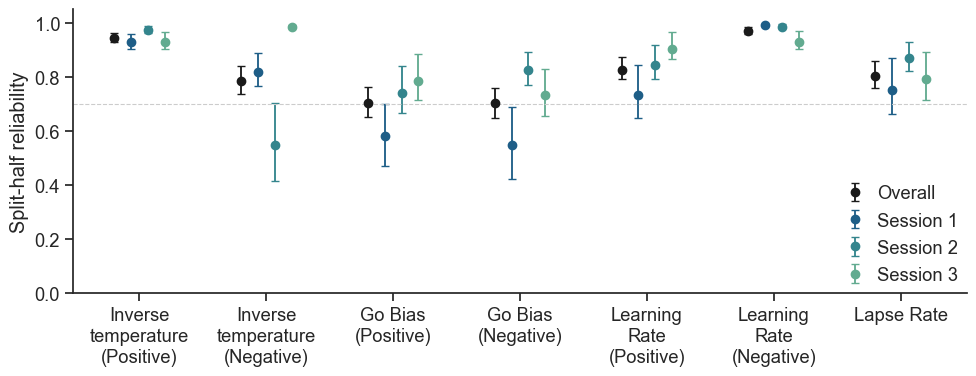

In [14]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
labels = ['Overall','Session 1','Session 2', 'Session 3']
offsets = np.linspace(-0.2,0.2,4)

for i, (offset, color, label) in enumerate(zip(offsets, palette, labels)):

    ## Define points.
    y = reliability.query(f'Type == "sh" and Group == {i}').Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(f'Type == "sh" and Group == {i}')['97.5%'] - y,
        y - reliability.query(f'Type == "sh" and Group == {i}')['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, label=label, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.legend(loc=4, frameon=False, borderpad=0, handletextpad=0.2)
ax.set(xticks=np.arange(7), ylim=(0,1.05), ylabel='Split-half reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()

### 5.2 Test-retest reliability

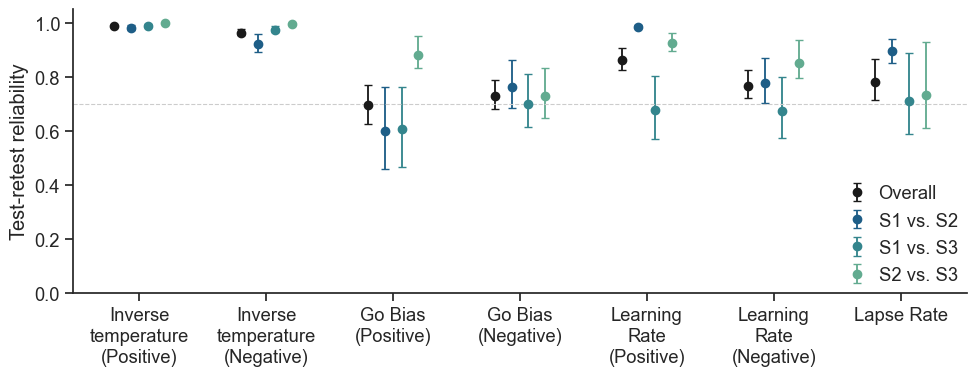

In [15]:
## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = np.append('k', sns.color_palette('crest_r', n_colors=3).as_hex())
labels = ['Overall','S1 vs. S2','S1 vs. S3', 'S2 vs. S3']
offsets = np.linspace(-0.2,0.2,4)

for i, (offset, color, label) in enumerate(zip(offsets, palette, labels)):

    ## Define query.
    query = f'Type == "trt" and Group == {i}'
    
    ## Define points.
    y = reliability.query(query).Mean
    x = np.arange(len(y)) + offset
    yerr = np.array([
        reliability.query(query)['97.5%'] - y,
        y - reliability.query(query)['2.5%']
    ])
    
    ## Plot.
    ax.errorbar(x, y, fmt='o', yerr=yerr, color=color, label=label, capsize=3, elinewidth=1.33)
    
## Add detail.
ax.axhline(0.7, color='0.8', lw=0.8, linestyle='--')
ax.legend(loc=4, frameon=False, borderpad=0, handletextpad=0.2)
ax.set(xticks=np.arange(7), ylim=(0,1.05), ylabel='Test-retest reliability')
ax.set_xticklabels(['Inverse\ntemperature\n(Positive)','Inverse\ntemperature\n(Negative)',
                    'Go Bias\n(Positive)','Go Bias\n(Negative)','Learning\nRate\n(Positive)',
                    'Learning\nRate\n(Negative)','Lapse Rate'])

sns.despine()
plt.tight_layout()

## Section 6: Comparison to Experiment 1

In [16]:
from os.path import dirname

## Define I/O parameters.
ROOT_DIR = dirname(dirname(os.path.realpath('__file__')))
studies = ['study01','study02']
sessions = ['s1','s2','s3']
stan_model = 'pgng_m7'

## Define contrasts.
cm1 = np.atleast_1d([1.0,1.0,1.0,-1.0,-1.0,-1.0]) / 3   # Difference between studies 
cm2 = np.atleast_1d([1.0,-0.5,-0.5,-1.0,0.5,0.5])       # Difference in practice effects between studies

### 6.1 Outcome sensitivity (reward)

In [17]:
## Define parameter.
param = 'b1_mu'

## Assemble data.
samples = []
for study in studies:

    for session in sessions:

        ## Load samples.
        f = os.path.join(ROOT_DIR, study, 'stan_results', session, f'{stan_model}.tsv.gz')
        tmp = read_csv(f, sep='\t', usecols=[param])

        ## Insert metadata. Append.
        tmp.insert(0, 'study', study)
        tmp.insert(1, 'session', session)
        tmp.insert(2, 'sample', np.arange(len(tmp))+1)
        samples.append(tmp)

## Concatentate DataFrames.
samples = concat(samples).pivot_table(param, 'sample', ['study', 'session']) 

## Compute contrasts.
for i, cm in enumerate([cm1, cm2]):

    ## Apply contrast matrix.
    csamp = samples.values @ cm

    ## Compute summary statistics.
    mu = np.mean(csamp)
    lb, ub = hdi(csamp, hdi_prob=0.95)
    print(f'Contrast {i+1}: mu = %0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

Contrast 1: mu = 15.895 [11.934, 19.832]
Contrast 2: mu = -17.106 [-23.753, -11.385]


### 6.2 Outcome sensitivity (punishing)

In [18]:
## Define parameter.
param = 'b2_mu'

## Assemble data.
samples = []
for study in studies:

    for session in sessions:

        ## Load samples.
        f = os.path.join(ROOT_DIR, study, 'stan_results', session, f'{stan_model}.tsv.gz')
        tmp = read_csv(f, sep='\t', usecols=[param])

        ## Insert metadata. Append.
        tmp.insert(0, 'study', study)
        tmp.insert(1, 'session', session)
        tmp.insert(2, 'sample', np.arange(len(tmp))+1)
        samples.append(tmp)

## Concatentate DataFrames.
samples = concat(samples).pivot_table(param, 'sample', ['study', 'session']) 

## Compute contrasts.
for i, cm in enumerate([cm1, cm2]):

    ## Apply contrast matrix.
    csamp = samples.values @ cm

    ## Compute summary statistics.
    mu = np.mean(csamp)
    lb, ub = hdi(csamp, hdi_prob=0.95)
    print(f'Contrast {i+1}: mu = %0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

Contrast 1: mu = 14.771 [10.531, 18.708]
Contrast 2: mu = -11.700 [-18.486, -4.777]


### 6.3 Learning rate (reward)

In [19]:
## Define parameter.
param = 'a1_mu'

## Assemble data.
samples = []
for study in studies:

    for session in sessions:

        ## Load samples.
        f = os.path.join(ROOT_DIR, study, 'stan_results', session, f'{stan_model}.tsv.gz')
        tmp = read_csv(f, sep='\t', usecols=[param])

        ## Insert metadata. Append.
        tmp.insert(0, 'study', study)
        tmp.insert(1, 'session', session)
        tmp.insert(2, 'sample', np.arange(len(tmp))+1)
        samples.append(tmp)

## Concatentate DataFrames.
samples = concat(samples).pivot_table(param, 'sample', ['study', 'session']) 

## Compute contrasts.
for i, cm in enumerate([cm1, cm2]):

    ## Apply contrast matrix.
    csamp = samples.values @ cm

    ## Compute summary statistics.
    mu = np.mean(csamp)
    lb, ub = hdi(csamp, hdi_prob=0.95)
    print(f'Contrast {i+1}: mu = %0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

Contrast 1: mu = -0.133 [-0.170, -0.094]
Contrast 2: mu = 0.015 [-0.068, 0.098]


### 6.4 Learning rate (punishing)

In [20]:
## Define parameter.
param = 'a2_mu'

## Assemble data.
samples = []
for study in studies:

    for session in sessions:

        ## Load samples.
        f = os.path.join(ROOT_DIR, study, 'stan_results', session, f'{stan_model}.tsv.gz')
        tmp = read_csv(f, sep='\t', usecols=[param])

        ## Insert metadata. Append.
        tmp.insert(0, 'study', study)
        tmp.insert(1, 'session', session)
        tmp.insert(2, 'sample', np.arange(len(tmp))+1)
        samples.append(tmp)

## Concatentate DataFrames.
samples = concat(samples).pivot_table(param, 'sample', ['study', 'session']) 

## Compute contrasts.
for i, cm in enumerate([cm1, cm2]):

    ## Apply contrast matrix.
    csamp = samples.values @ cm

    ## Compute summary statistics.
    mu = np.mean(csamp)
    lb, ub = hdi(csamp, hdi_prob=0.95)
    print(f'Contrast {i+1}: mu = %0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

Contrast 1: mu = -0.170 [-0.218, -0.122]
Contrast 2: mu = -0.186 [-0.301, -0.079]


### 6.5 Action bias (reward)

In [21]:
## Define parameter.
param = 'b3_mu'

## Assemble data.
samples = []
for study in studies:

    for session in sessions:

        ## Load samples.
        f = os.path.join(ROOT_DIR, study, 'stan_results', session, f'{stan_model}.tsv.gz')
        tmp = read_csv(f, sep='\t', usecols=[param])

        ## Insert metadata. Append.
        tmp.insert(0, 'study', study)
        tmp.insert(1, 'session', session)
        tmp.insert(2, 'sample', np.arange(len(tmp))+1)
        samples.append(tmp)

## Concatentate DataFrames.
samples = concat(samples).pivot_table(param, 'sample', ['study', 'session']) 

## Compute contrasts.
for i, cm in enumerate([cm1, cm2]):

    ## Apply contrast matrix.
    csamp = samples.values @ cm

    ## Compute summary statistics.
    mu = np.mean(csamp)
    lb, ub = hdi(csamp, hdi_prob=0.95)
    print(f'Contrast {i+1}: mu = %0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

Contrast 1: mu = 0.300 [0.093, 0.500]
Contrast 2: mu = 0.145 [-0.289, 0.593]


### 6.6 Action bias (punishing)

In [22]:
## Define parameter.
param = 'b4_mu'

## Assemble data.
samples = []
for study in studies:

    for session in sessions:

        ## Load samples.
        f = os.path.join(ROOT_DIR, study, 'stan_results', session, f'{stan_model}.tsv.gz')
        tmp = read_csv(f, sep='\t', usecols=[param])

        ## Insert metadata. Append.
        tmp.insert(0, 'study', study)
        tmp.insert(1, 'session', session)
        tmp.insert(2, 'sample', np.arange(len(tmp))+1)
        samples.append(tmp)

## Concatentate DataFrames.
samples = concat(samples).pivot_table(param, 'sample', ['study', 'session']) 

## Compute contrasts.
for i, cm in enumerate([cm1, cm2]):

    ## Apply contrast matrix.
    csamp = samples.values @ cm

    ## Compute summary statistics.
    mu = np.mean(csamp)
    lb, ub = hdi(csamp, hdi_prob=0.95)
    print(f'Contrast {i+1}: mu = %0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

Contrast 1: mu = 0.188 [0.047, 0.317]
Contrast 2: mu = -0.351 [-0.606, -0.097]
